In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from scipy import stats
from scipy.stats import norm, skew

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GroupKFold, GridSearchCV, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import BayesianRidge,LogisticRegression, PassiveAggressiveClassifier, RidgeClassifier, OrthogonalMatchingPursuit
from sklearn.svm import SVR, NuSVR, LinearSVR
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KNeighborsRegressor, KernelDensity, KDTree
from sklearn.metrics import *

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import sys, os
import random 

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
from IPython import display, utils

# 1. 데이터 가져오기

In [2]:
train = pd.read_csv('aug_train.csv')
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,Male,22,1,7.0,1,< 1 Year,No,2630.0,152.0,16,0
1,17163,Male,42,1,28.0,0,1-2 Year,Yes,43327.0,26.0,135,0
2,32023,Female,66,1,33.0,0,1-2 Year,Yes,35841.0,124.0,253,0
3,87447,Female,22,1,33.0,0,< 1 Year,No,27645.0,152.0,69,0
4,501933,Male,28,1,46.0,1,< 1 Year,No,29023.0,152.0,211,0


In [3]:
train.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000,382154.000000
mean,234392.953477,38.545691,0.998108,26.406867,0.489182,30711.271362,111.939812,154.189429,0.163811
std,139527.487326,15.226897,0.043455,13.181241,0.499884,17061.595532,54.286511,83.735107,0.370104
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,115006.250000,25.000000,1.000000,15.000000,0.000000,24546.000000,26.000000,81.000000,0.000000
50%,230461.500000,36.000000,1.000000,28.000000,0.000000,31692.000000,145.000000,154.000000,0.000000
75%,345434.750000,49.000000,1.000000,35.000000,1.000000,39447.750000,152.000000,227.000000,0.000000
max,508145.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [4]:
test = pd.read_csv('aug_test.csv')
test.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,57782,Female,34,1,39.0,1,1-2 Year,No,38244.0,124.0,146
1,286811,Female,55,1,28.0,0,> 2 Years,Yes,37577.0,122.0,109
2,117823,Male,39,1,28.0,1,1-2 Year,No,24578.0,26.0,63
3,213992,Male,28,1,50.0,1,1-2 Year,No,40507.0,8.0,129
4,324756,Female,24,1,10.0,0,< 1 Year,Yes,36783.0,152.0,201


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  object 
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  object 
 7   Vehicle_Damage        382154 non-null  object 
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 35.0+ MB


In [6]:
train.describe(include=['O'])

,Gender,Vehicle_Age,Vehicle_Damage
count,382154,382154,382154
unique,2,3,2
top,Male,1-2 Year,No
freq,205603,200176,198501


# 2. EDA

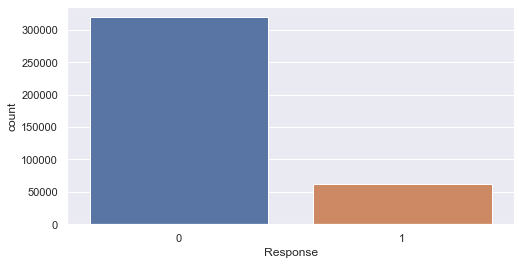

In [7]:
target = train.Response
sns.set()
plt.figure(figsize=(8, 4))
sns.countplot(target)

In [8]:
t_nums = ['Age', 'Annual_Premium','Vintage']
t_cats = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel' ]

In [9]:
def analyse_cats(df, cat_cols):
    d = pd.DataFrame()
    c1, u, s, nans = [], [], [], []
    for c in cat_cols:
        c1.append(c)
        u.append(df[c].unique())
        s.append(df[c].unique().size)
        nans.append(df[c].isnull().sum())
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
        sns.countplot(train[c], ax=axes[0], label='train', palette='bone')
        sns.countplot(test[c], ax=axes[1], label='test')
        
        axes[0].set_title('train')
        axes[1].set_title('test')
        
    d['feat'] = c1
    d['uniques'] = u
    d['cardinality'] = s
    d['nans'] = nans
    
    return d

,feat,uniques,cardinality,nans
0,Gender,"[Male, Female]",2,0
1,Vehicle_Age,"[< 1 Year, 1-2 Year, > 2 Years]",3,0
2,Vehicle_Damage,"[No, Yes]",2,0
3,Driving_License,"[1, 0]",2,0
4,Region_Code,"[7.0, 28.0, 33.0, 46.0, 25.0, 8.0, 41.0, 39.0,...",53,0
5,Previously_Insured,"[1, 0]",2,0
6,Policy_Sales_Channel,"[152.0, 26.0, 124.0, 122.0, 158.0, 157.0, 156....",156,0


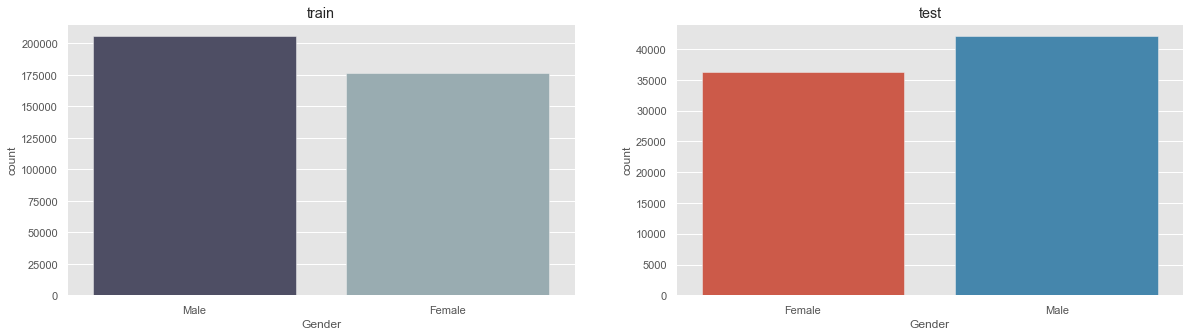

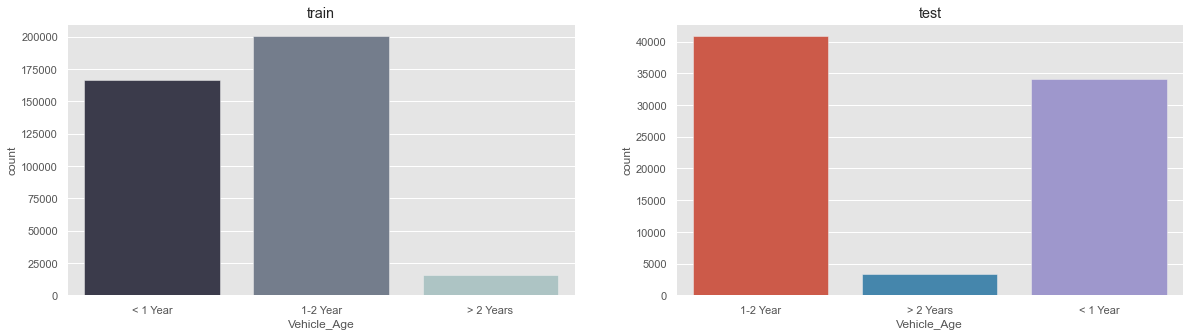

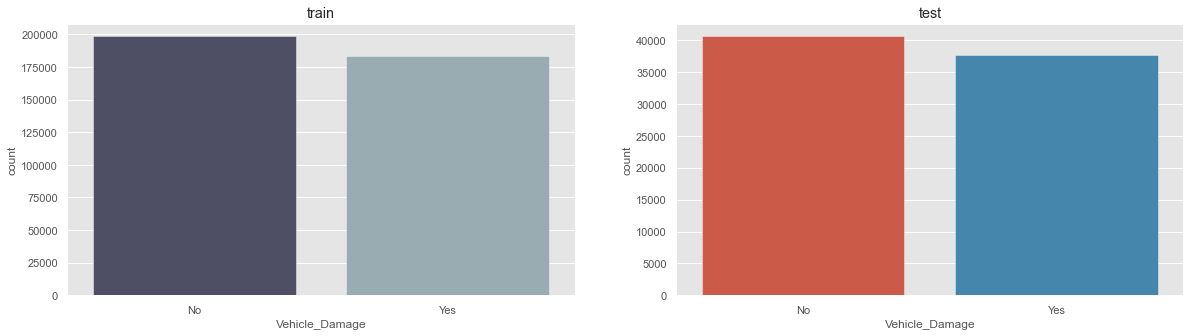

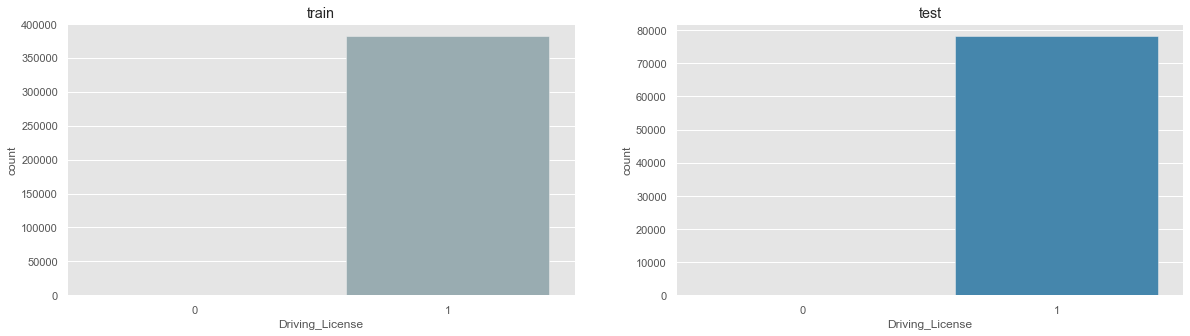

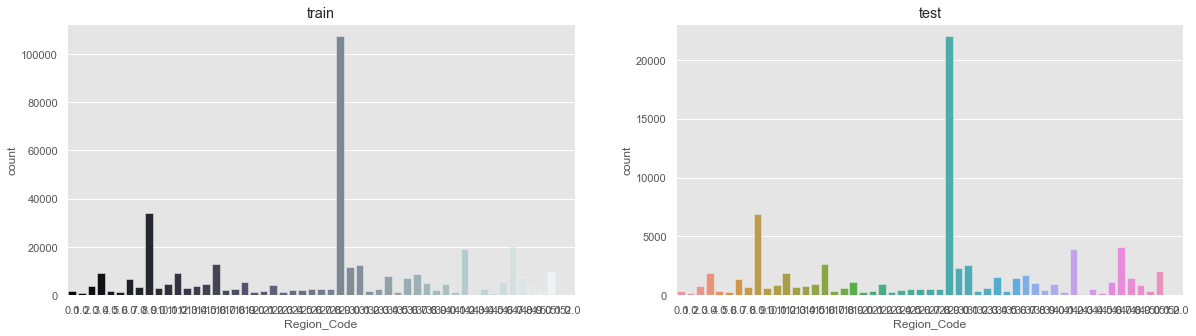

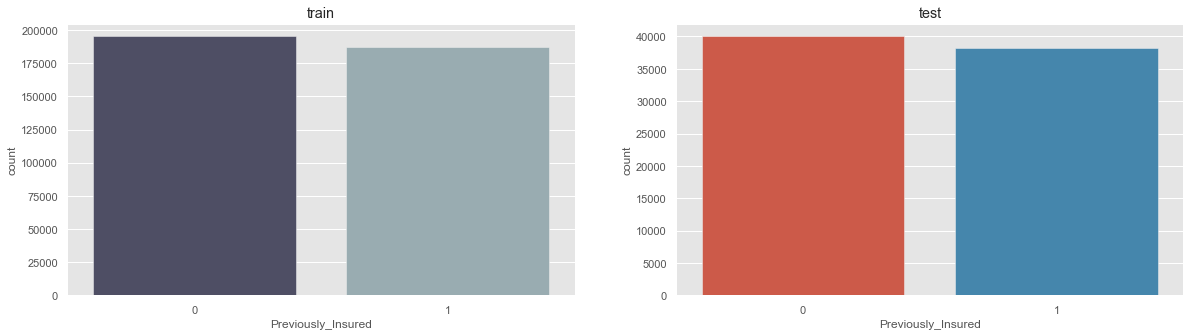

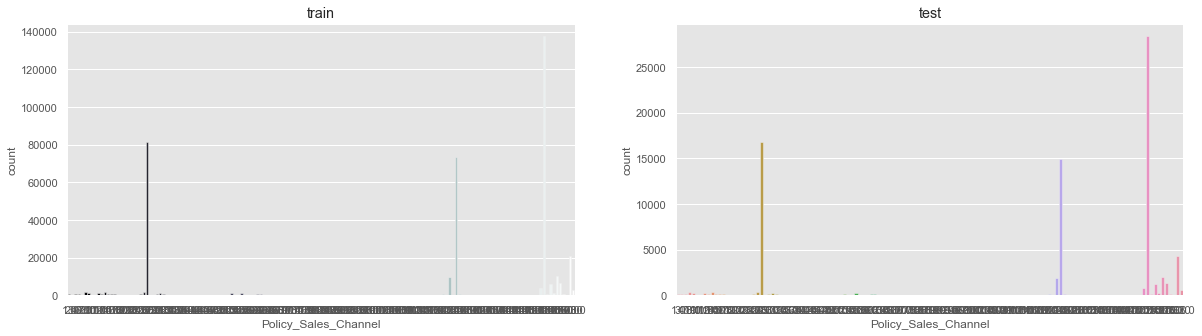

In [10]:
plt.style.use('ggplot')
analyse_cats(train, t_cats)

<Figure size 7200x5760 with 0 Axes>

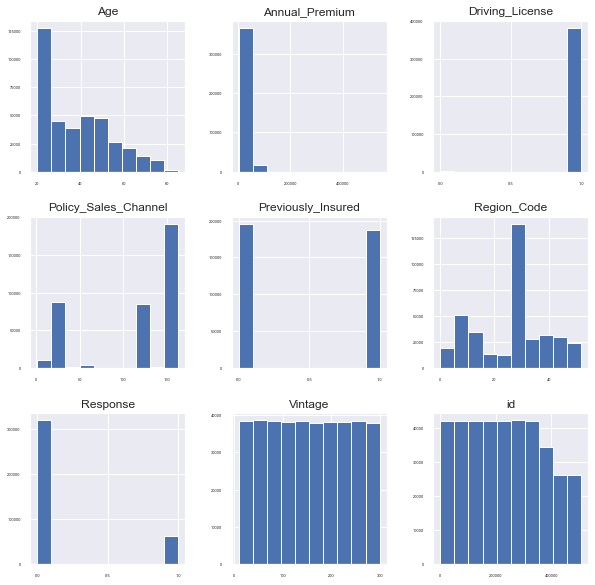

In [11]:
# 히스토그램 그려서 변수별 분포 확인
sns.set()
plt.figure(figsize=(100, 80))
train.hist(sharex=False, sharey=False, xlabelsize=4, ylabelsize=4, figsize=(10, 10))
plt.style.use('ggplot')
plt.show()

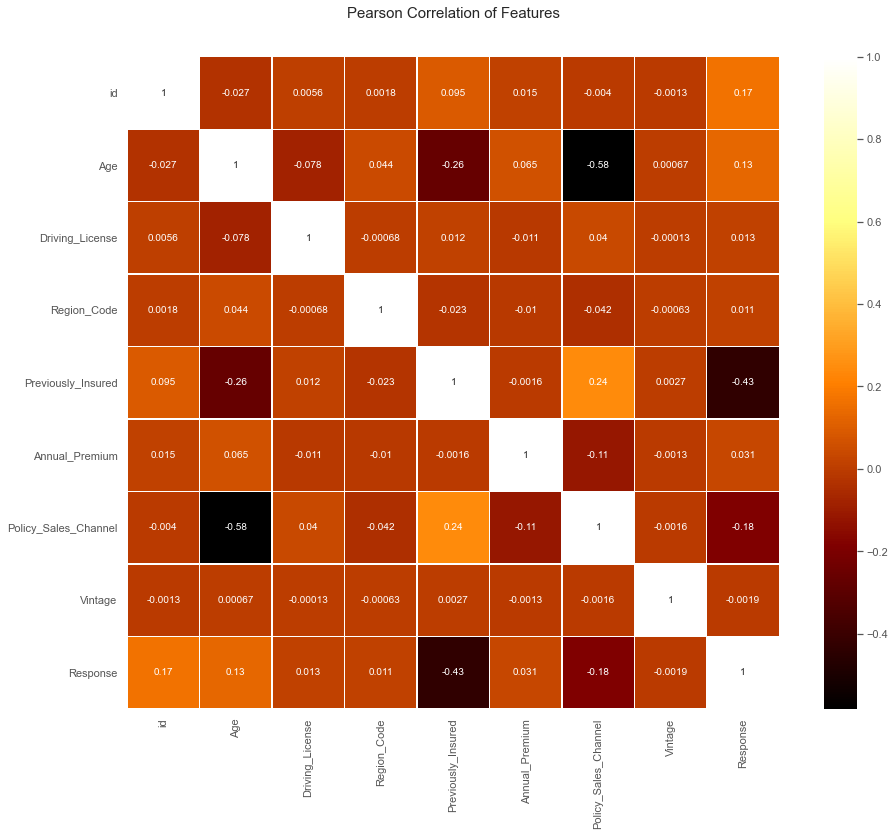

In [12]:
# Pearson correlation map -> High correlation 거의 없음
colormap = plt.cm.afmhot
plt.figure(figsize=(16, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

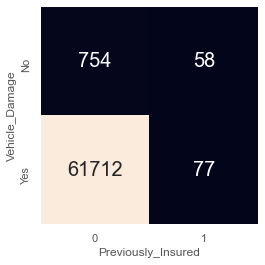

In [13]:
train_1 = train[train['Response'] == 1]

train_1 = train_1[['Vehicle_Damage', 'Previously_Insured', 'Response']]

train_1 = train_1.groupby(['Vehicle_Damage', 'Previously_Insured']).size().unstack()

sns.heatmap(data=train_1, annot=True, square=True, fmt='d', cbar=False, annot_kws={'size':20})

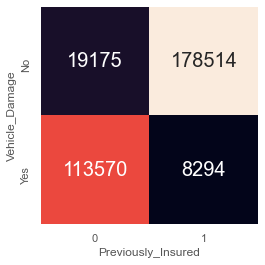

In [14]:
train_0 = train[train['Response'] == 0]

train_0 = train_0[['Vehicle_Damage', 'Previously_Insured', 'Response']]

train_0 = train_0.groupby(['Vehicle_Damage', 'Previously_Insured']).size().unstack()

sns.heatmap(data=train_0, annot=True, square=True, fmt='d', cbar=False, annot_kws={'size':20})

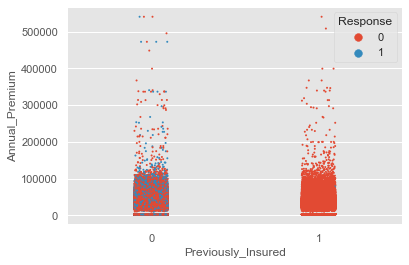

In [15]:
sns.stripplot(data=train, x="Previously_Insured", y="Annual_Premium", hue="Response", size=2)

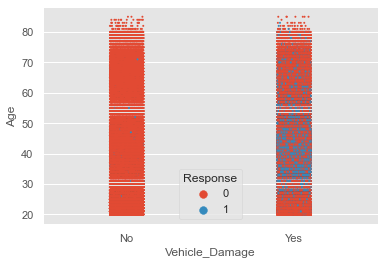

In [16]:
sns.stripplot(data=train, x="Vehicle_Damage", y="Age", hue="Response", size=2)

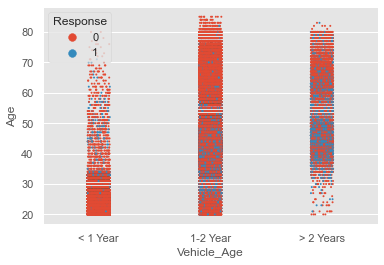

In [17]:
sns.stripplot(data=train, x="Vehicle_Age", y="Age", hue="Response", size=2)

# 3. 데이터 분할 및 전처리

In [18]:
cats = [c for c in train.columns if train[c].dtypes == 'object']
print('Categories', cats)

nums = [c for c in train.columns if c not in cats]
print('Numerics', nums)

Categories ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
Numerics ['id', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']


In [19]:
for c in cats:
    le = LabelEncoder()
    le.fit(list(train[c].astype('str')) + list(test[c].astype('str')))
    train[c] = le.transform(list(train[c].astype(str)))
    test[c] = le.transform(list(test[c].astype(str)))

train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,167647,1,22,1,7.0,1,1,0,2630.0,152.0,16,0
1,17163,1,42,1,28.0,0,0,1,43327.0,26.0,135,0
2,32023,0,66,1,33.0,0,0,1,35841.0,124.0,253,0
3,87447,0,22,1,33.0,0,1,0,27645.0,152.0,69,0
4,501933,1,28,1,46.0,1,1,0,29023.0,152.0,211,0


In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    382154 non-null  int64  
 1   Gender                382154 non-null  int64  
 2   Age                   382154 non-null  int64  
 3   Driving_License       382154 non-null  int64  
 4   Region_Code           382154 non-null  float64
 5   Previously_Insured    382154 non-null  int64  
 6   Vehicle_Age           382154 non-null  int64  
 7   Vehicle_Damage        382154 non-null  int64  
 8   Annual_Premium        382154 non-null  float64
 9   Policy_Sales_Channel  382154 non-null  float64
 10  Vintage               382154 non-null  int64  
 11  Response              382154 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 35.0 MB


In [21]:
del train['id']
del test['id']

target = train.pop('Response')

train.shape, test.shape

((382154, 10), (78273, 10))

In [22]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.30, stratify=target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(267507, 10) (267507,)
(114647, 10) (114647,)


## SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

In [24]:
smote = SMOTE()
X_smote, y_smote = smote.fit_sample(train, target)

X_smote.shape, y_smote.shape

((639106, 10), (639106,))

In [25]:
y_smote.value_counts()

1    319553
0    319553
Name: Response, dtype: int64

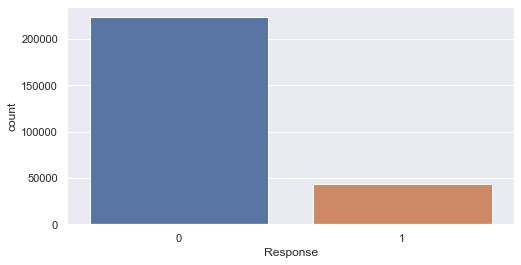

In [29]:
sns.set()
plt.figure(figsize=(8, 4))
sns.countplot(y_train)

In [27]:
X_smote = pd.DataFrame(X_smote, columns=train.columns)

X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(X_smote, y_smote, test_size=0.30, stratify=y_smote, random_state=1)

## CF 함수 정의

In [32]:
def cf_matrix(y_test, y_pred):
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(7, 7))

    sns.heatmap(cf_matrix, square=True, annot=labels, cbar=False, fmt='', annot_kws={'size':24})
    plt.xlabel('Predicted')
    plt.ylabel('True Values')
    
    return None

# 4. 모델 최적화

## Logistic Regression

#### SMOTE X

In [21]:
lr = LogisticRegression(random_state=0)

param_grid = {'C': [0.001, 1, 1000], 
              'tol': [0.001, 1, 1000]}

gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)
print('GS Best score: %.3f' % (gs.best_score_))
print(gs.best_params_)

opt = gs.best_estimator_
opt.fit(X_train, y_train)
y_pred = opt.predict(X_test) # opt.predict_proba(X_test)로 확률값 계산 가능 (cutoff 설정해서 크면 1, 작으면 0으로 지정)

print('Train acc: %.3f' % (opt.score(X_train, y_train)))
print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: Area Under Curve: {}'.format(roc_auc_score(y_test, y_pred_proba[:, 1])))

print(classification_report(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Values')

GS Best score: 0.738
{'C': 1, 'tol': 0.001}
Train acc: 0.831
Test acc: 0.831


NameError: name 'y_pred_proba' is not defined

Test acc: 0.831
AUC: 0.680
log loss: 0.422
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     95867
           1       0.24      0.02      0.03     18780

    accuracy                           0.83    114647
   macro avg       0.54      0.50      0.47    114647
weighted avg       0.74      0.83      0.76    114647



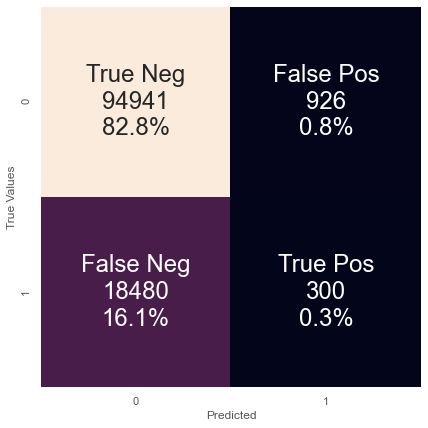

In [73]:
lr = LogisticRegression(C=1, tol=0.001, random_state=0)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
y_pred_proba = lr.predict_proba(X_test)

print('Test acc: %.3f' % (lr.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

#### SMOTE O

GS Best score: 0.772
{'C': 0.001, 'tol': 0.001}
Train acc: 0.732
Test acc: 0.731
              precision    recall  f1-score   support

           0       0.96      0.71      0.81     95867
           1       0.36      0.86      0.51     18780

    accuracy                           0.73    114647
   macro avg       0.66      0.78      0.66    114647
weighted avg       0.86      0.73      0.76    114647



Text(89.18, 0.5, 'True Values')

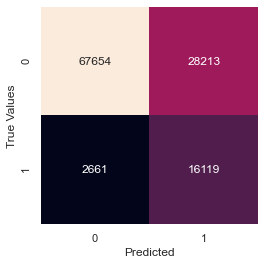

In [33]:
lr = LogisticRegression(random_state=0)

param_grid = {'C': [0.001, 1, 1000], 
              'tol': [0.001, 1, 1000]}

gs = GridSearchCV(estimator=lr, param_grid=param_grid, scoring='roc_auc', cv=5)
gs.fit(X_smote_train, y_smote_train)
print('GS Best score: %.3f' % (gs.best_score_))
print(gs.best_params_)

opt = gs.best_estimator_
opt.fit(X_smote_train, y_smote_train)
y_pred = opt.predict(X_test) # opt.predict_proba(X_test)로 확률값 계산 가능 (cutoff 설정해서 크면 1, 작으면 0으로 지정)

print('Train acc: %.3f' % (opt.score(X_train, y_train)))
print('Test acc: %.3f' % (opt.score(X_test, y_test)))
#print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Values')

Test acc: 0.629
AUC: 0.676
log loss: 0.658
              precision    recall  f1-score   support

           0       0.88      0.65      0.74     95867
           1       0.23      0.55      0.33     18780

    accuracy                           0.63    114647
   macro avg       0.56      0.60      0.54    114647
weighted avg       0.77      0.63      0.68    114647



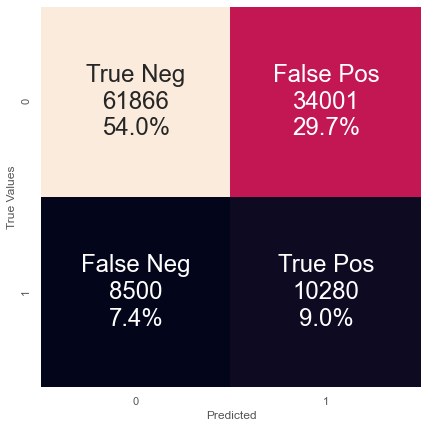

In [77]:
opt = LogisticRegression(C=0.001, tol=0.001, random_state=0)

opt.fit(X_smote_train, y_smote_train)
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

## Random Forest

#### SMOTE X

GS Best score: 0.892
{'max_depth': 9, 'max_features': 6}
Train acc: 0.844
Test acc: 0.844


Text(89.18, 0.5, 'True Values')

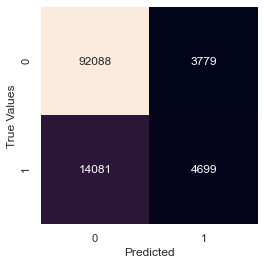

In [34]:
rf = RandomForestClassifier(random_state=0)

param_grid = {'max_depth': [5, 9, None], 
              'max_features': [3, 6, 9]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)
print('GS Best score: %.3f' % (gs.best_score_))
print(gs.best_params_)

opt = gs.best_estimator_
opt.fit(X_train, y_train)
y_pred = opt.predict(X_test)

print('Train acc: %.3f' % (opt.score(X_train, y_train)))
print('Test acc: %.3f' % (opt.score(X_test, y_test)))
#print(confusion_matrix(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Values')

Test acc: 0.831
AUC: 0.893
log loss: 0.277
              precision    recall  f1-score   support

           0       0.87      0.96      0.91     95867
           1       0.55      0.25      0.34     18780

    accuracy                           0.84    114647
   macro avg       0.71      0.61      0.63    114647
weighted avg       0.82      0.84      0.82    114647



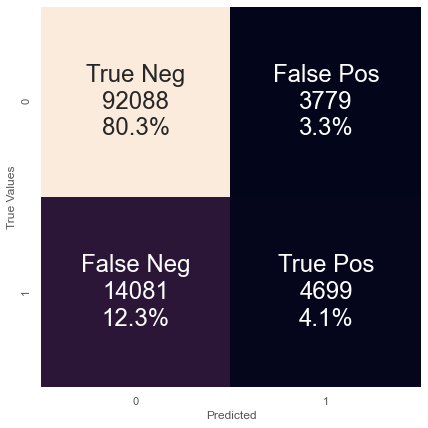

In [79]:
opt = RandomForestClassifier(max_depth=9, max_features=6, random_state=0)

opt.fit(X_train, y_train)
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

#### SMOTE O

GS Best score: 0.966
{'max_depth': None, 'max_features': 9}
Train acc: 0.983
Test acc: 0.875


Text(89.18, 0.5, 'True Values')

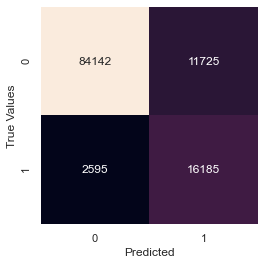

In [35]:
rf = RandomForestClassifier(random_state=0)

param_grid = {'max_depth': [5, 9, None], 
              'max_features': [3, 6, 9]}

gs = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='roc_auc', cv=5)
gs.fit(X_smote_train, y_smote_train)
print('GS Best score: %.3f' % (gs.best_score_))
print(gs.best_params_)

opt = gs.best_estimator_
opt.fit(X_smote_train, y_smote_train)
y_pred = opt.predict(X_test)

print('Train acc: %.3f' % (opt.score(X_train, y_train)))
print('Test acc: %.3f' % (opt.score(X_test, y_test)))
#print(confusion_matrix(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Values')

Test acc: 0.831
AUC: 0.944
log loss: 0.280
              precision    recall  f1-score   support

           0       0.97      0.88      0.92     95867
           1       0.58      0.86      0.69     18780

    accuracy                           0.87    114647
   macro avg       0.77      0.87      0.81    114647
weighted avg       0.91      0.87      0.88    114647



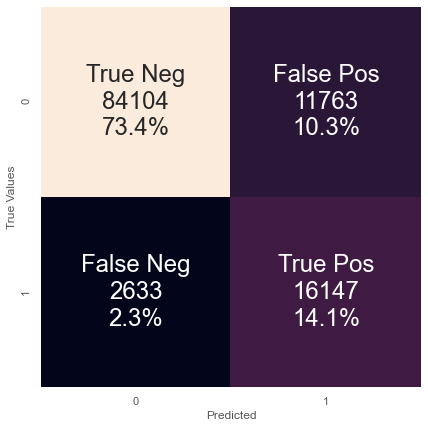

In [80]:
opt = RandomForestClassifier(max_depth=None, max_features=9, random_state=0)

opt.fit(X_smote_train, y_smote_train)
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

## XGBoost

#### SMOTE X

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier(random_state=0)

param_grid = {'max_depth': [6], 
              'colsample_bytree': [0.7]}

gs = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5)
gs.fit(X_train, y_train)
print('GS Best score: %.3f' % (gs.best_score_))
print(gs.best_params_)

opt = gs.best_estimator_
opt.fit(X_train, y_train)

y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: Area Under Curve: {}'.format(roc_auc_score(y_test, y_pred_proba[:, 1])))

print(classification_report(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Values')

KeyboardInterrupt: 

Test acc: 0.831
AUC: 0.895
log loss: 0.275
              precision    recall  f1-score   support

           0       0.89      0.93      0.91     95867
           1       0.54      0.40      0.46     18780

    accuracy                           0.85    114647
   macro avg       0.72      0.67      0.69    114647
weighted avg       0.83      0.85      0.84    114647



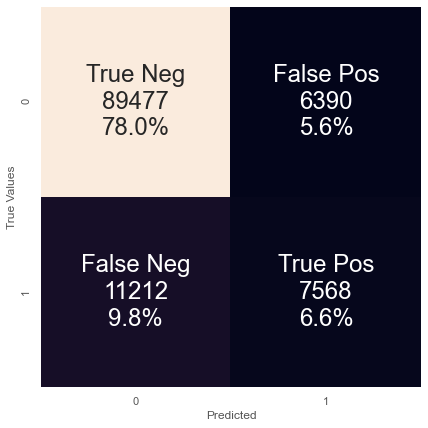

In [87]:
from xgboost import XGBClassifier

opt = XGBClassifier(colsample_bytree=0.7, max_depth=6, random_state=0)

opt.fit(X_train, y_train)
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

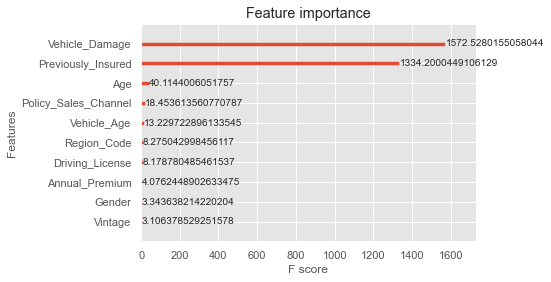

In [89]:
from xgboost import plot_importance

plot_importance(opt, importance_type='gain')

#### SMOTE O

GS Best score: 0.970
{'colsample_bytree': 0.7, 'max_depth': 6}
Train acc: 0.840
Test acc: 0.837
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     95867
           1       0.50      0.71      0.59     18780

    accuracy                           0.84    114647
   macro avg       0.72      0.78      0.74    114647
weighted avg       0.87      0.84      0.85    114647



Text(89.18, 0.5, 'True Values')

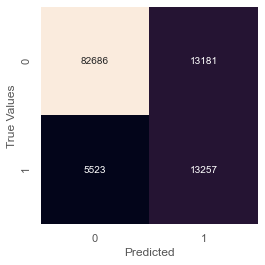

In [20]:
xgb = XGBClassifier(random_state=0)

param_grid = {'max_depth': [6], 
              'colsample_bytree': [0.7]}

gs = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='roc_auc', cv=5)
gs.fit(X_smote_train, y_smote_train)
print('GS Best score: %.3f' % (gs.best_score_))
print(gs.best_params_)

opt = gs.best_estimator_
opt.fit(X_smote_train, y_smote_train)

y_pred = opt.predict(X_test)

print('Train acc: %.3f' % (opt.score(X_train, y_train)))
print('Test acc: %.3f' % (opt.score(X_test, y_test)))
#print(confusion_matrix(y_test, y_pred))

print(classification_report(y_test, y_pred))

mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True Values')

Test acc: 0.831
AUC: 0.893
log loss: 0.297
              precision    recall  f1-score   support

           0       0.94      0.86      0.90     95867
           1       0.50      0.71      0.59     18780

    accuracy                           0.84    114647
   macro avg       0.72      0.79      0.74    114647
weighted avg       0.87      0.84      0.85    114647



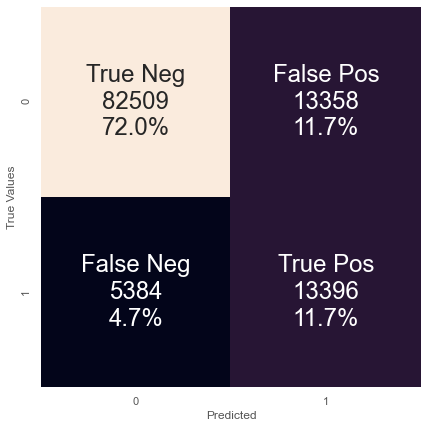

In [90]:
opt = XGBClassifier(colsample_bytree=0.7, max_depth=6, random_state=0)

opt.fit(X_smote_train, y_smote_train)
y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

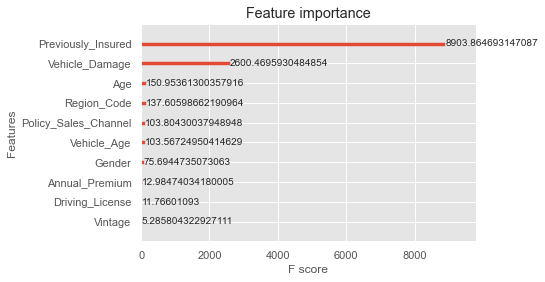

In [91]:
plot_importance(opt, importance_type='gain')

## CatBoost

In [23]:
#!pip install catboost

In [92]:
from catboost import CatBoostClassifier

In [93]:
train = pd.read_csv('aug_train.csv')

del train['id']

target = train.pop('Response')

train.shape, target.shape

((382154, 10), (382154,))

In [94]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382154 entries, 0 to 382153
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                382154 non-null  object 
 1   Age                   382154 non-null  int64  
 2   Driving_License       382154 non-null  int64  
 3   Region_Code           382154 non-null  float64
 4   Previously_Insured    382154 non-null  int64  
 5   Vehicle_Age           382154 non-null  object 
 6   Vehicle_Damage        382154 non-null  object 
 7   Annual_Premium        382154 non-null  float64
 8   Policy_Sales_Channel  382154 non-null  float64
 9   Vintage               382154 non-null  int64  
dtypes: float64(3), int64(4), object(3)
memory usage: 29.2+ MB


In [95]:
train['Region_Code'] = train['Region_Code'].astype(int)
train['Annual_Premium'] = train['Annual_Premium'].astype(int)
train['Policy_Sales_Channel'] = train['Policy_Sales_Channel'].astype(int)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.30,
                                                    stratify=target, random_state=1)

#### SMOTE X

0:	learn: 0.3550808	total: 34.1ms	remaining: 3.38s
1:	learn: 0.3067064	total: 79.3ms	remaining: 3.88s
2:	learn: 0.2891832	total: 125ms	remaining: 4.04s
3:	learn: 0.2804475	total: 180ms	remaining: 4.31s
4:	learn: 0.2784705	total: 229ms	remaining: 4.35s
5:	learn: 0.2761453	total: 281ms	remaining: 4.4s
6:	learn: 0.2750256	total: 327ms	remaining: 4.34s
7:	learn: 0.2744486	total: 369ms	remaining: 4.25s
8:	learn: 0.2738297	total: 420ms	remaining: 4.25s
9:	learn: 0.2732620	total: 475ms	remaining: 4.27s
10:	learn: 0.2729479	total: 527ms	remaining: 4.26s
11:	learn: 0.2726045	total: 580ms	remaining: 4.25s
12:	learn: 0.2723078	total: 631ms	remaining: 4.22s
13:	learn: 0.2716463	total: 682ms	remaining: 4.19s
14:	learn: 0.2714637	total: 733ms	remaining: 4.15s
15:	learn: 0.2710519	total: 785ms	remaining: 4.12s
16:	learn: 0.2707667	total: 833ms	remaining: 4.07s
17:	learn: 0.2704799	total: 881ms	remaining: 4.01s
18:	learn: 0.2700544	total: 930ms	remaining: 3.96s
19:	learn: 0.2697717	total: 979ms	remain

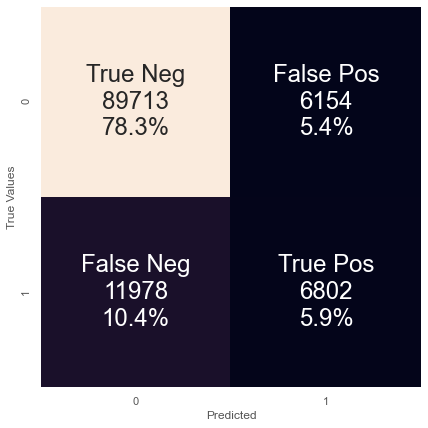

In [98]:
cat_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel']

opt = CatBoostClassifier(iterations=100, learning_rate=1, depth=10)
opt.fit(X_train, y_train, cat_features)

y_pred = opt.predict(X_test)
y_pred_proba = opt.predict_proba(X_test)

print('Test acc: %.3f' % (opt.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

#### SMOTE O

In [99]:
X_smote_train['Region_Code'] = X_smote_train['Region_Code'].astype(int)
X_smote_train['Annual_Premium'] = X_smote_train['Annual_Premium'].astype(int)
X_smote_train['Policy_Sales_Channel'] = X_smote_train['Policy_Sales_Channel'].astype(int)

In [100]:
X_smote_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447374 entries, 492463 to 99906
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   Gender                447374 non-null  int64
 1   Age                   447374 non-null  int64
 2   Driving_License       447374 non-null  int64
 3   Region_Code           447374 non-null  int64
 4   Previously_Insured    447374 non-null  int64
 5   Vehicle_Age           447374 non-null  int64
 6   Vehicle_Damage        447374 non-null  int64
 7   Annual_Premium        447374 non-null  int64
 8   Policy_Sales_Channel  447374 non-null  int64
 9   Vintage               447374 non-null  int64
dtypes: int64(10)
memory usage: 37.5 MB


In [101]:
X_test['Region_Code'] = X_test['Region_Code'].astype(int)
X_test['Annual_Premium'] = X_test['Annual_Premium'].astype(int)
X_test['Policy_Sales_Channel'] = X_test['Policy_Sales_Channel'].astype(int)

In [102]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114647 entries, 126351 to 117248
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Gender                114647 non-null  object
 1   Age                   114647 non-null  int64 
 2   Driving_License       114647 non-null  int64 
 3   Region_Code           114647 non-null  int64 
 4   Previously_Insured    114647 non-null  int64 
 5   Vehicle_Age           114647 non-null  object
 6   Vehicle_Damage        114647 non-null  object
 7   Annual_Premium        114647 non-null  int64 
 8   Policy_Sales_Channel  114647 non-null  int64 
 9   Vintage               114647 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 9.6+ MB


0:	learn: 0.3851283	total: 65.6ms	remaining: 6.5s
1:	learn: 0.3387987	total: 140ms	remaining: 6.84s
2:	learn: 0.3136532	total: 225ms	remaining: 7.26s
3:	learn: 0.3072114	total: 294ms	remaining: 7.07s
4:	learn: 0.3025381	total: 359ms	remaining: 6.82s
5:	learn: 0.2997128	total: 420ms	remaining: 6.58s
6:	learn: 0.2984973	total: 483ms	remaining: 6.41s
7:	learn: 0.2977529	total: 553ms	remaining: 6.37s
8:	learn: 0.2965689	total: 622ms	remaining: 6.29s
9:	learn: 0.2952710	total: 686ms	remaining: 6.17s
10:	learn: 0.2946815	total: 747ms	remaining: 6.05s
11:	learn: 0.2938816	total: 806ms	remaining: 5.91s
12:	learn: 0.2933282	total: 865ms	remaining: 5.79s
13:	learn: 0.2926598	total: 931ms	remaining: 5.72s
14:	learn: 0.2919409	total: 996ms	remaining: 5.65s
15:	learn: 0.2916167	total: 1.07s	remaining: 5.64s
16:	learn: 0.2911335	total: 1.15s	remaining: 5.61s
17:	learn: 0.2907884	total: 1.21s	remaining: 5.49s
18:	learn: 0.2902052	total: 1.27s	remaining: 5.42s
19:	learn: 0.2900315	total: 1.33s	remaini

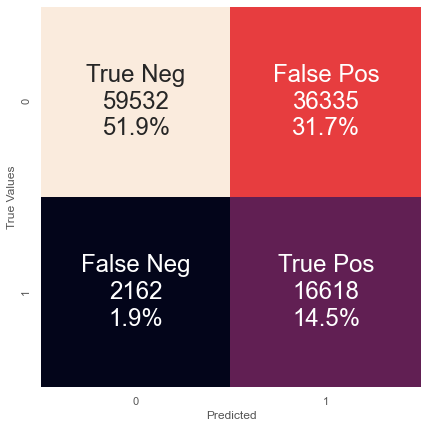

In [103]:
cat_features = ['Gender', 'Vehicle_Age', 'Vehicle_Damage', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Policy_Sales_Channel']

model = CatBoostClassifier(iterations=100, learning_rate=1, depth=10)
model.fit(X_smote_train, y_smote_train, cat_features)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)

print('Test acc: %.3f' % (model.score(X_test, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

# 5. AutoML

## AutoKeras

In [61]:
!pip install tensorflow

     |████████████████████████████████| 165.2 MB 7.5 MB/s eta 0:00:01
     |████████████████████████████████| 57 kB 5.4 MB/s eta 0:00:01
     |████████████████████████████████| 65 kB 7.5 MB/s eta 0:00:011
     |████████████████████████████████| 127 kB 6.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 7.2 MB/s eta 0:00:01
     |████████████████████████████████| 3.6 MB 8.0 MB/s eta 0:00:01
     |████████████████████████████████| 459 kB 8.1 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 3.9 MB/s eta 0:00:011
     |████████████████████████████████| 10.6 MB 7.9 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 6.1 MB/s eta 0:00:011
     |████████████████████████████████| 114 kB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 779 kB 6.5 MB/s eta 0:00:01
     |████████████████████████████████| 47 kB 9.0 MB/s  eta 0:00:01
     |████████████████████████████████| 155 kB 7.1 MB/s eta 0:00:01
     |████████████████████████████████| 77 kB 

In [62]:
!pip install autokeras

     |████████████████████████████████| 164 kB 1.9 MB/s eta 0:00:01
     |████████████████████████████████| 62 kB 4.5 MB/s  eta 0:00:01
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-py3-none-any.whl size=78936 sha256=c3fc117fca42cdfc8d436be1d931d4a2ea462a3bc0588e7f1b0d4f0516f45faf
  Stored in directory: /Users/kwonsoonjae/Library/Caches/pip/wheels/53/3d/c3/160c686bd74a18989843fcd015e8f6954ca8d834fd2ef4658a
  Created wheel for terminaltables: filename=terminaltables-3.1.0-py3-none-any.whl size=15354 sha256=fd9b4e4bbd3b1ea52afab37d75fbfeb017bf6de178e3f8df770ea8dbfce6f4a5
  Stored in directory: /Users/kwonsoonjae/Library/Caches/pip/wheels/08/8f/5f/253d0105a55bd84ee61ef0d37dbf70421e61e0cd70cef7c5e1
Successfully built keras-tuner terminaltables


In [30]:
import tensorflow as tf
import autokeras as ak

3583/3583 [==============================] - 2s 669us/step - loss: 0.2819 - accuracy: 0.8415
[0.2818792462348938, 0.8415135145187378]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91     95867
           1       0.53      0.29      0.37     18780

    accuracy                           0.84    114647
   macro avg       0.70      0.62      0.64    114647
weighted avg       0.82      0.84      0.82    114647



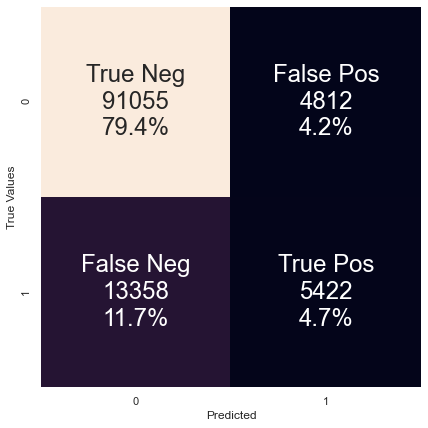

In [35]:
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=5)
clf.fit(X_train, y_train, epochs=10)

y_pred = clf.predict(X_test)
#y_pred_proba = clf.predict_proba(x_test)

print(clf.evaluate(X_test, y_test))

#print("log loss:", log_loss(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

Trial 5 Complete [00h 04m 22s]
val_accuracy: 0.8551546335220337

Best val_accuracy So Far: 0.8586648106575012
Total elapsed time: 00h 22m 08s
INFO:tensorflow:Oracle triggered exit

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/20
13981/13981 [==============================] - 11s 800us/step - loss: 0.3472 - accuracy: 0.8484
Epoch 2/20
13981/13981 [==============================] - 12s 828us/step - loss: 0.3387 - accuracy: 0.8527
Epoch 3/20
13981/13981 [==============================] - 11s 821us/step - loss: 0.3364 - accuracy: 0.8534
Epoch 4

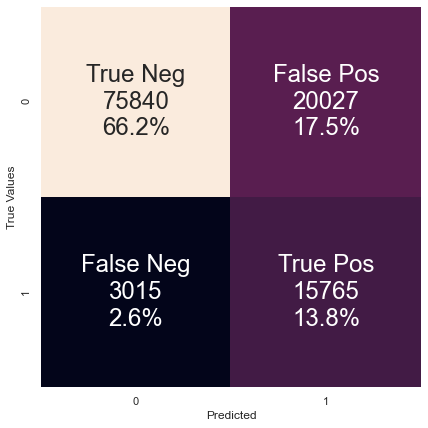

In [36]:
clf = ak.StructuredDataClassifier(overwrite=True, max_trials=5)
clf.fit(X_smote_train, y_smote_train, epochs=20)

y_pred = clf.predict(X_test)
#y_pred_proba = clf.predict_proba(x_test)

print(clf.evaluate(X_test, y_test))

#print("log loss:", log_loss(y_test, y_pred_proba))
print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

## H2O

In [198]:
!pip install requests
!pip install tabulate
!pip install “colorama>=0.3.8”
!pip install future

!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

zsh:1: 0.3.8” not found
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 164.6 MB 94 kB/s  eta 0:00:01
  Created wheel for h2o: filename=h2o-3.32.0.2-py2.py3-none-any.whl size=164620456 sha256=a2f10594e691c07cd142e1722717222060a18d0a3687ecfb96e80588076a7b67
  Stored in directory: /Users/kwonsoonjae/Library/Caches/pip/wheels/1e/35/bb/5d98c23dfccffc9476dfdd3377beaf2dad7e0eaee795496238
Successfully built h2o


In [37]:
import h2o
h2o.init(nthreads=-1, max_mem_size=8)

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,2 days 3 hours 13 mins
H2O_cluster_timezone:,Asia/Seoul
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_kwonsoonjae_acm1pt
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2.149 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [38]:
from h2o.sklearn import H2OAutoMLClassifier

In [39]:
y_train = pd.DataFrame(y_train)

### balance_classes 적용 (Overfitting 방지)

In [48]:
aml = H2OAutoMLClassifier(max_models=20, max_runtime_secs=500, seed=1, 
                          sort_metric='logloss', balance_classes=True)

aml.fit(X_train, y_train)
y_pred = aml.predict(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |███████████Failed polling AutoML progress log: Unexpected HTTP error: ('Connection aborted.', BadStatusLine('GET /3/Frames/py_3222_sid_aee4?row_count=10&row_offset=0&column_count=-1&full_column_count=-1&column_offset=0 HTTP/1.1\r\n'))
█████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.96      0.84      0.89     95867
           1       0.49      0.80      0.61     18780

    accuracy                           0.83    114647
   macro avg       0.72      0.82      0.75    114647
weighted avg       0.88      0.83      0.85    114647



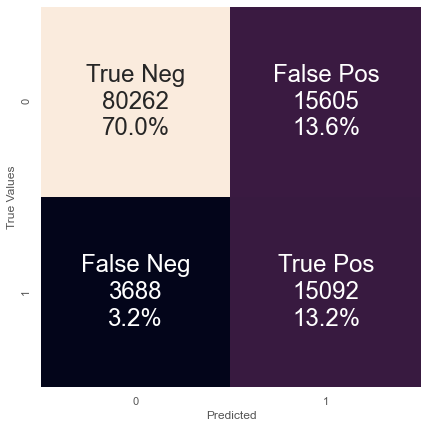

In [51]:
print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

In [34]:
automl = aml.estimator

automl.leaderboard

NameError: name 'aml' is not defined

### balance_classes 미적용

In [40]:
aml = H2OAutoMLClassifier(max_models=20, max_runtime_secs=500, seed=1, 
                          sort_metric='logloss')

aml.fit(X_train, y_train)
y_pred = aml.predict(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████Failed polling AutoML progress log: Unexpected HTTP error: ('Connection aborted.', BadStatusLine('POST /99/Rapids HTTP/1.1\r\n'))
████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
xgboost prediction progress: |████████████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.96      0.84      0.89     95867
           1       0.49      0.80      0.61     18780

    accuracy                           0.83    114647
   macro avg       0.72      0.82      0.75    114647
weighted avg       0.88      0.83      0.85    114647



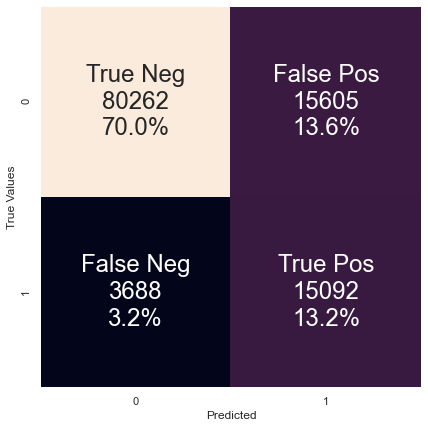

In [41]:
print(classification_report(y_test, y_pred))
cf_matrix(y_test, y_pred)

In [42]:
automl = aml.estimator

automl.leaderboard

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20201217_063447_model_1,0.274159,0.895081,0.519365,0.181937,0.304795,0.0928997
XGBoost_3_AutoML_20201217_063447,0.274933,0.894452,0.517885,0.182178,0.305254,0.0931803
GBM_1_AutoML_20201217_063447,0.275987,0.894773,0.518552,0.182952,0.305169,0.0931281
GBM_3_AutoML_20201217_063447,0.277104,0.895283,0.519803,0.181186,0.304839,0.092927
GBM_2_AutoML_20201217_063447,0.277162,0.894678,0.517575,0.178306,0.305167,0.0931271
XGBoost_1_AutoML_20201217_063447,0.277502,0.894306,0.51535,0.180325,0.305203,0.0931491
GBM_grid__1_AutoML_20201217_063447_model_1,0.278576,0.891758,0.507994,0.180864,0.307606,0.0946213
GBM_4_AutoML_20201217_063447,0.280195,0.895025,0.516846,0.18205,0.305084,0.0930761
GBM_grid__1_AutoML_20201217_063447_model_2,0.284074,0.889845,0.502617,0.185584,0.308097,0.094924
DeepLearning_1_AutoML_20201217_063447,0.284103,0.885152,0.49004,0.183978,0.309871,0.0960199


### SMOTE 적용

In [44]:
y_smote_train = pd.DataFrame(y_smote_train)

In [45]:
aml = H2OAutoMLClassifier(max_models=20, max_runtime_secs=500, seed=1, 
                          sort_metric='logloss')

aml.fit(X_smote_train, y_smote_train)
y_pred = aml.predict(X_test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


              precision    recall  f1-score   support

           0       0.96      0.84      0.90     95867
           1       0.50      0.80      0.62     18780

    accuracy                           0.84    114647
   macro avg       0.73      0.82      0.76    114647
weighted avg       0.88      0.84      0.85    114647



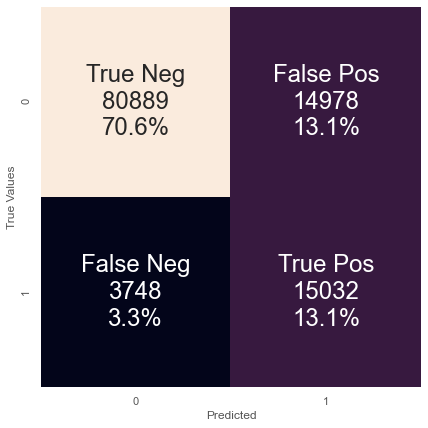

In [46]:
print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

In [47]:
automl = aml.estimator

automl.leaderboard

model_id,logloss,auc,aucpr,mean_per_class_error,rmse,mse
GBM_grid__1_AutoML_20201215_193636_model_1,0.256566,0.963127,0.96312,0.114944,0.280576,0.0787227
StackedEnsemble_BestOfFamily_AutoML_20201215_193636,0.256998,0.963332,0.963215,0.114408,0.28262,0.0798741
StackedEnsemble_AllModels_AutoML_20201215_193636,0.257045,0.963315,0.963207,0.114812,0.282698,0.0799179
XGBoost_grid__1_AutoML_20201215_193636_model_1,0.25983,0.958109,0.9568,0.119817,0.287335,0.0825616
XGBoost_1_AutoML_20201215_193636,0.313081,0.947714,0.9409,0.125781,0.304916,0.0929739
XRT_1_AutoML_20201215_193636,0.315768,0.947966,0.941744,0.12454,0.297297,0.0883857
DRF_1_AutoML_20201215_193636,0.326106,0.947819,0.941475,0.125144,0.297038,0.0882316
XGBoost_3_AutoML_20201215_193636,0.326501,0.928659,0.908109,0.13725,0.318621,0.101519
DeepLearning_1_AutoML_20201215_193636,0.331659,0.917871,0.89341,0.147581,0.326372,0.106519
GBM_3_AutoML_20201215_193636,0.346341,0.934502,0.91524,0.130877,0.320452,0.10269


# 변수 선택 (큰 효과 없어 미포함)

In [49]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=3)
X_smote_train_pca = pca.fit_transform(X_smote_train)
X_test_pca = pca.fit_transform(X_test)

print(pca.explained_variance_ratio_)

[9.99964405e-01 2.42025012e-05 1.02780738e-05]


Test acc: 0.344
AUC: 0.378
log loss: 2.995
              precision    recall  f1-score   support

           0       0.78      0.30      0.43     95867
           1       0.14      0.58      0.23     18780

    accuracy                           0.34    114647
   macro avg       0.46      0.44      0.33    114647
weighted avg       0.68      0.34      0.40    114647



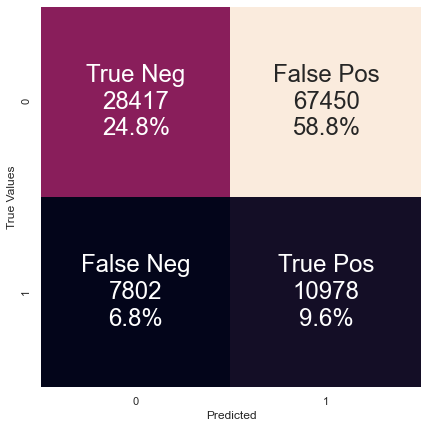

In [51]:
opt = RandomForestClassifier(max_depth=None, max_features=3, random_state=0)

opt.fit(X_smote_train_pca, y_smote_train)
y_pred = opt.predict(X_test_pca)
y_pred_proba = opt.predict_proba(X_test_pca)

print('Test acc: %.3f' % (opt.score(X_test_pca, y_test)))
print('AUC: %.3f' % (roc_auc_score(y_test, y_pred_proba[:, 1])))
print('log loss: %.3f' % (log_loss(y_test, y_pred_proba)))

print(classification_report(y_test, y_pred))

cf_matrix(y_test, y_pred)

# EoD.